# Target Fluctuations

This notebook is not a complete effort, although it does contain several potentially useful plots which show how QSO, ELG, BGS, and LRG target density varies with Galactic reddening and imaging depth (based on DR5). 

The bottom of the notebook also contains a simple regression of target density versus reddening, which we use in `desitarget.mock.targets_truth`. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
from astropy.table import Table

In [3]:
from sklearn.mixture import GaussianMixture as GMM

In [4]:
import seaborn as sns
sns.set(style='white', font_scale=1.1, palette='deep')

In [5]:
%matplotlib inline

### Read the heapix information table for DR5...
...take the log of the densities, and convert to a pandas dataframe.

In [6]:
def read_infotable():
    infofile = os.path.join(os.getenv('DESI_ROOT'), 'target', 'catalogs', 'hp-info-dr5-0.17.1.fits')
    info = Table.read(infofile)
    cols = ['{}DEPTH_{}_PERCENTILES'.format(prefix, band) for band in ('G', 'R', 'Z') for prefix in ('PSF', 'GAL')]
    for target in ('ELG', 'LRG', 'QSO', 'BGS'):
        with np.errstate(all='ignore'):
            info['DENSITY_{}'.format(target)] = np.log10(info['DENSITY_{}'.format(target)])
    info.remove_columns(cols)
    return info.to_pandas()    

In [7]:
_info = read_infotable()
_info

,HPXID,HPXAREA,RA,DEC,EBV,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,...,NEXP_G,NEXP_R,NEXP_Z,DENSITY_ALL,DENSITY_ELG,DENSITY_LRG,DENSITY_QSO,DENSITY_LYA,DENSITY_BGS,DENSITY_MWS
0,0,0.052456,45.000000,0.149208,0.088500,24.575624,24.286928,23.380188,24.343454,23.938946,...,4,2,3,5261.567383,3.373628,2.771568,2.558960,0.0,3.337111,0.0
1,1,0.052456,45.175781,0.298417,0.106785,24.486000,24.268520,23.200266,24.241188,23.930630,...,3,2,2,4899.357910,3.387416,2.742604,2.660417,0.0,3.243994,0.0
2,2,0.052456,44.824219,0.298417,0.083006,24.630730,24.333153,23.313522,24.393602,23.978317,...,4,2,2,5985.985840,3.362991,2.581236,2.234449,0.0,3.513202,0.0
3,3,0.052456,45.000000,0.447628,0.090561,24.559509,24.311333,23.288239,24.317987,23.964497,...,3,2,2,4823.103516,3.384010,2.771568,2.394149,0.0,3.234448,0.0
4,4,0.052456,45.351562,0.447628,0.106791,24.343983,24.076357,23.164227,24.101957,23.745398,...,2,1,2,4251.193848,3.344664,2.711570,2.321599,0.0,3.155267,0.0
5,5,0.052456,45.527344,0.596842,0.097694,24.225916,23.954306,23.153233,23.985544,23.622919,...,2,1,2,2573.592773,3.106281,2.581236,2.125304,0.0,2.970402,0.0
6,6,0.052456,45.175781,0.596842,0.095500,24.465931,24.220013,23.273710,24.224958,23.882454,...,3,2,2,4098.684570,3.348392,2.641934,2.456297,0.0,3.119055,0.0
7,7,0.052456,45.351562,0.746060,0.093295,24.284094,24.047815,23.294277,24.030888,23.734314,...,2,1,3,4308.384766,3.309590,2.798720,2.484326,0.0,3.194020,0.0
8,8,0.052456,44.648438,0.447628,0.081472,24.618589,24.345335,23.159859,24.374355,23.986643,...,3,2,2,5032.803223,3.370111,2.359387,2.426334,0.0,3.373628,0.0
9,9,0.052456,44.824219,0.596842,0.083834,24.632193,24.349581,23.189117,24.392372,23.990971,...,4,2,2,5490.331055,3.473331,2.660417,2.581236,0.0,3.284527,0.0


#### Select healpixels with three or more exposures in all three (*grz*) bands.
The caps on density are to toss out a handful of couple outliers.

In [8]:
minexp = 3

In [9]:
info = _info.loc[(_info['NEXP_G'] >= minexp) & (_info['NEXP_R'] >= minexp) & 
                 (_info['NEXP_Z'] >= minexp) & 
                 np.isfinite(_info['DENSITY_ELG']) & 
                 np.isfinite(_info['DENSITY_LRG']) & 
                 np.isfinite(_info['DENSITY_BGS']) & 
                 np.isfinite(_info['DENSITY_QSO'])
                 #(_info['DENSITY_ELG'] < 5000) & (_info['DENSITY_ELG'] > 0) & 
                 #(_info['DENSITY_LRG'] < 1500) & (_info['DENSITY_LRG'] > 0) & 
                 #(_info['DENSITY_BGS'] < 6000) & (_info['DENSITY_BGS'] > 0) & 
                 #(_info['DENSITY_QSO'] < 1000) & (_info['DENSITY_QSO'] > 0) 
                ]
print('There are {} / {} healpixels with >={} exposures in grz.'.format(len(info), len(_info), minexp))

There are 42741 / 152849 healpixels with >=3 exposures in grz.


### Visualize the relationships between density, depth, and reddening for each target class.

In [10]:
def pairplot(target, only_dust=False):
    if only_dust:
        cols = ['DENSITY_{}'.format(target), 'EBV']
    else:
        cols = ['DENSITY_{}'.format(target), 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'EBV']
    print(info[cols].describe())
    sns.pairplot(info, vars=cols, diag_kind='hist', plot_kws={'s': 3}, size=2)

        DENSITY_ELG    GALDEPTH_G    GALDEPTH_R    GALDEPTH_Z           EBV
count  42741.000000  42741.000000  42741.000000  42741.000000  42741.000000
mean       3.374060     24.505133     24.110043     23.032774      0.041722
std        0.086989      0.308172      0.312294      0.251312      0.022888
min        1.581236     22.579695     21.880945     22.227142      0.008564
25%        3.325529     24.326187     23.896286     22.867973      0.026394
50%        3.380577     24.463923     24.125931     23.013962      0.035180
75%        3.429425     24.668438     24.283543     23.179966      0.049815
max        3.757327     25.882170     25.414646     24.174570      0.244828


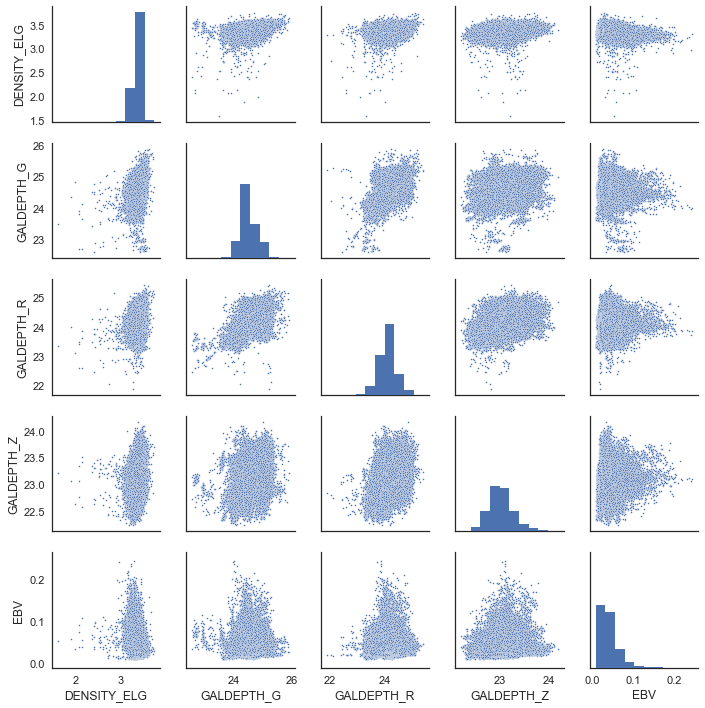

In [11]:
pairplot('ELG')

        DENSITY_LRG    GALDEPTH_G    GALDEPTH_R    GALDEPTH_Z           EBV
count  42741.000000  42741.000000  42741.000000  42741.000000  42741.000000
mean       2.644160     24.505133     24.110043     23.032774      0.041722
std        0.146595      0.308172      0.312294      0.251312      0.022888
min        1.280206     22.579695     21.880945     22.227142      0.008564
25%        2.558960     24.326187     23.896286     22.867973      0.026394
50%        2.660417     24.463923     24.125931     23.013962      0.035180
75%        2.742604     24.668438     24.283543     23.179966      0.049815
max        3.256887     25.882170     25.414646     24.174570      0.244828


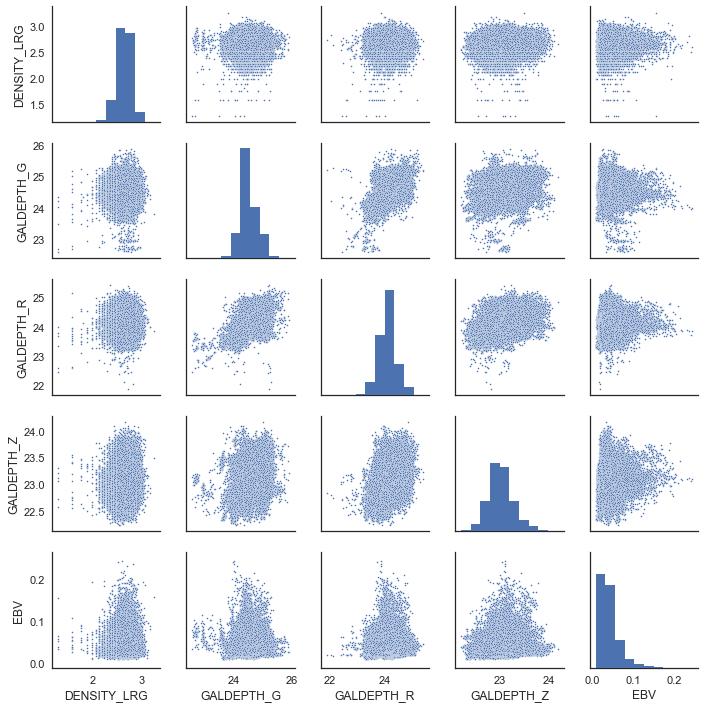

In [12]:
pairplot('LRG')

        DENSITY_QSO    GALDEPTH_G    GALDEPTH_R    GALDEPTH_Z           EBV
count  42741.000000  42741.000000  42741.000000  42741.000000  42741.000000
mean       2.370539     24.505133     24.110043     23.032774      0.041722
std        0.157054      0.308172      0.312294      0.251312      0.022888
min        1.280206     22.579695     21.880945     22.227142      0.008564
25%        2.280206     24.326187     23.896286     22.867973      0.026394
50%        2.394149     24.463923     24.125931     23.013962      0.035180
75%        2.484326     24.668438     24.283543     23.179966      0.049815
max        3.591960     25.882170     25.414646     24.174570      0.244828


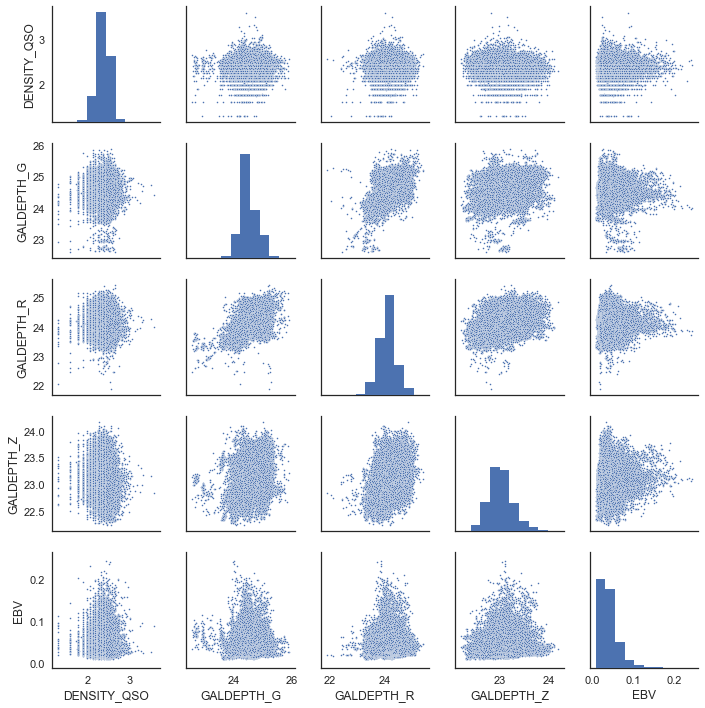

In [13]:
pairplot('QSO')

        DENSITY_BGS    GALDEPTH_G    GALDEPTH_R    GALDEPTH_Z           EBV
count  42741.000000  42741.000000  42741.000000  42741.000000  42741.000000
mean       3.278477     24.505133     24.110043     23.032774      0.041722
std        0.114281      0.308172      0.312294      0.251312      0.022888
min        1.882266     22.579695     21.880945     22.227142      0.008564
25%        3.204485     24.326187     23.896286     22.867973      0.026394
50%        3.275841     24.463923     24.125931     23.013962      0.035180
75%        3.348392     24.668438     24.283543     23.179966      0.049815
max        4.036081     25.882170     25.414646     24.174570      0.244828


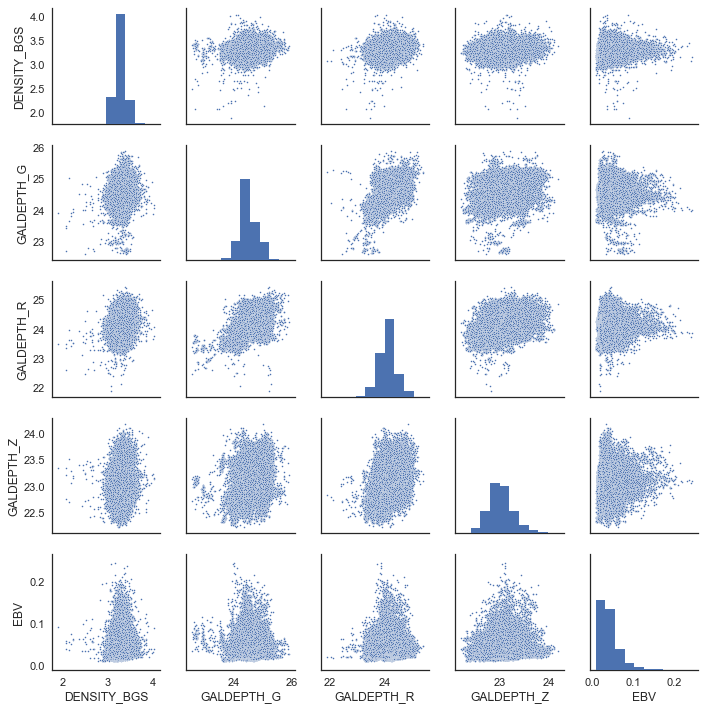

In [14]:
pairplot('BGS')

### Determine the number of Gaussian components needed for each target class.

Regress just the QSOs against the dust reddening for now, to demonstrate the method.  Unfortunately, a simple mixture of Gaussians does not appear to be a good representation of the data (i.e., the Bayesian information criterion, BIC, does not converge), so this approach requires more work.

In [15]:
ncomparray = np.arange(10, 50)

In [16]:
def qa_bic(ncomp, bic, title):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(ncomp, bic, marker='s', ls='-')
    ax.set_xlabel('Number of Gaussian Components')
    ax.set_ylabel('Bayesian Information Criterion')
    ax.set_title(title)

In [17]:
def getbic(target, ncomp=[3]):
    cols = ['DENSITY_{}'.format(target), 'EBV']
    X = info[cols]
    bic = [GMM(n_components=nc).fit(X).bic(X) for nc in ncomp]
    return bic

In [18]:
%time bic_qso = getbic('QSO', ncomparray)

CPU times: user 5min 27s, sys: 11.4 s, total: 5min 39s
Wall time: 1min 25s


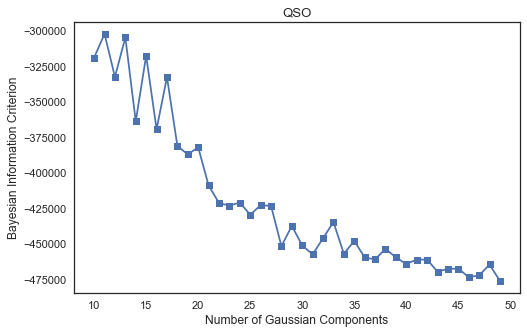

In [19]:
qa_bic(ncomparray, bic_qso, title='QSO')

In [20]:
qsocols = ['DENSITY_QSO', 'EBV']

In [21]:
mog = GMM(n_components=25).fit(info[qsocols])

#### QSO pairplot and data

        DENSITY_QSO           EBV
count  42741.000000  42741.000000
mean       2.370539      0.041722
std        0.157054      0.022888
min        1.280206      0.008564
25%        2.280206      0.026394
50%        2.394149      0.035180
75%        2.484326      0.049815
max        3.591960      0.244828


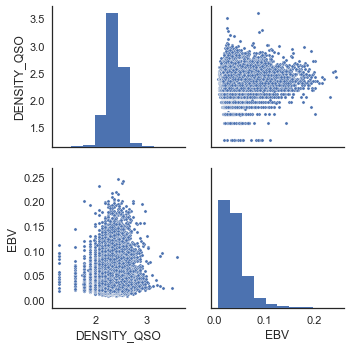

In [22]:
print(info[qsocols].describe())
sns.pairplot(info[qsocols], plot_kws={'s': 10})

#### QSO pairplot and model

Note how the model does not capture the correlation and spread in the data, especially at high reddening.

In [24]:
samp = pd.DataFrame(np.vstack(mog.sample(1000)[0]), columns=qsocols)

       DENSITY_QSO          EBV
count  1000.000000  1000.000000
mean      2.365006     0.041066
std       0.150573     0.022535
min       1.579644    -0.014273
25%       2.279986     0.026766
50%       2.361255     0.038653
75%       2.460854     0.051553
max       2.836147     0.212188


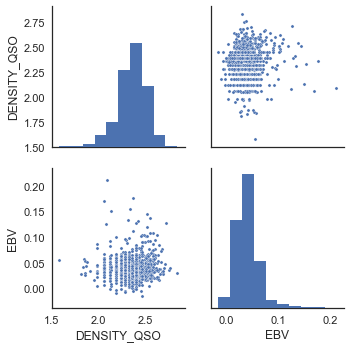

In [25]:
print(samp.describe())
sns.pairplot(samp, plot_kws={'s': 10})

### Model (log) density vs E(B-V), for each target class.

In [26]:
def medxbin(x, y, binsize, minpts=20, xmin=None, xmax=None):
    """
    Compute the median (and other statistics) in fixed bins along the x-axis.
    """
    import numpy as np
    from scipy import ptp

    if xmin == None:
        xmin = x.min()
    if xmax == None:
        xmax = x.max()

    nbin = int(ptp(x) / binsize)
    bins = np.linspace(xmin, xmax, nbin)
    idx  = np.digitize(x, bins)

    stats = np.zeros(nbin,[('med', 'f4'), ('sig', 'f4'), 
                           ('q25', 'f4'), ('q75', 'f4') ])
    for kk in np.arange(nbin):
        npts = len(y[idx == kk])
        if npts > minpts:
            stats['med'][kk] = np.median(y[idx == kk])
            stats['sig'][kk] = np.std(y[idx == kk])
            stats['q25'][kk] = np.percentile(y[idx == kk], 25)
            stats['q75'][kk] = np.percentile(y[idx == kk], 75)

    good = np.nonzero(stats['med'])
    stats = stats[good]

    return bins[good], stats

In [27]:
def density_vs_ebv(info, target, order=2, doplot=True, ylim=None):

    xx, yy = info['EBV'].values, info['DENSITY_{}'.format(target)].values
    
    if ylim:
        good = (yy > ylim[0]) * (yy < ylim[1])
    else:
        good = np.ones(len(yy), dtype='bool')

    bins, stats = medxbin(xx[good], yy[good], 0.01, minpts=10, xmin=0)

    coeff = np.polyfit(bins, stats['med'], order)
    
    #from desiutil.funcfits import iter_fit
    #fit, mask = iter_fit(xx, yy, 'polynomial', order, sig_rej=10)
    #good = np.where(mask == 0)[0]
    #coeff = fit['coeff']
    #scatter = np.std(yy[good] - np.polyval(coeff, xx[good]))

    med = 10**np.mean(stats['med'])
    sig = np.log(10) * med * np.mean(stats['sig'])
    scatter = np.std(yy[good] - np.polyval(coeff, xx[good]))
    print('{}: median={:.2f}+/-{:.2f} deg2'.format(target, med, sig))
    print('  Slope, Intercept, scatter = {:.5f}, {:.3f}, {:.3f}'.format(coeff[0], coeff[1],
                                                                        scatter))
    
    if doplot:
        fig, ax = plt.subplots()
        ax.scatter(xx, yy, s=5, alpha=0.5)
        ax.plot(bins, stats['med'], lw=3, ls='-', color='orange')
        ax.plot(bins, stats['med'] + stats['sig'], lw=3, ls='--', color='orange')
        ax.plot(bins, stats['med'] - stats['sig'], lw=3, ls='--', color='orange')
        #ax.plot(bins, stats['q25'], lw=3, ls='--', color='orange')
        #ax.plot(bins, stats['q75'], lw=3, ls='--', color='orange')

        xaxis = np.linspace(xx.min(), xx.max(), 100)
        ax.plot(xaxis, np.polyval(coeff, xaxis), color='red', lw=2, alpha=0.5)
        #ax.plot(xaxis, np.polyval(coeff, xaxis) + scatter)
        #ax.plot(xaxis, np.polyval(coeff, xaxis) - scatter)
        
        ax.set_xlabel(r'$E(B-V)$')
        ax.set_ylabel(r'$\log_{{10}}\ (N\ {}\ /\ {{\rm deg}}^2)$'.format(target))
        
        if ylim:
            ax.set_ylim(ylim)
                                                                 
    return coeff

QSO: median=246.57+/-94.91 deg2
  Slope, Intercept, scatter = 0.02972, 2.389, 0.157


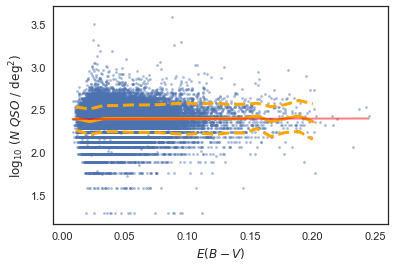

In [28]:
coeff = density_vs_ebv(info, 'QSO', order=1)

ELG: median=2092.90+/-441.48 deg2
  Slope, Intercept, scatter = -0.55792, 3.380, 0.081


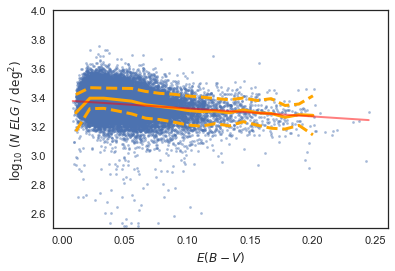

In [32]:
coeff = density_vs_ebv(info, 'ELG', order=1, ylim=(2.5, 4))

LRG: median=457.16+/-161.89 deg2
  Slope, Intercept, scatter = 0.27216, 2.631, 0.145


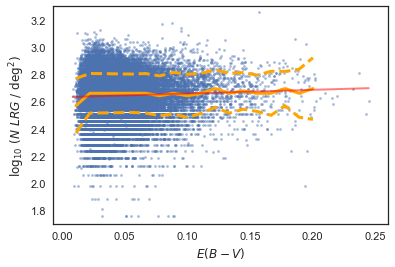

In [30]:
coeff = density_vs_ebv(info, 'LRG', order=1, ylim=(1.7, 3.3))

BGS: median=1925.66+/-519.12 deg2
  Slope, Intercept, scatter = 0.33321, 3.249, 0.112


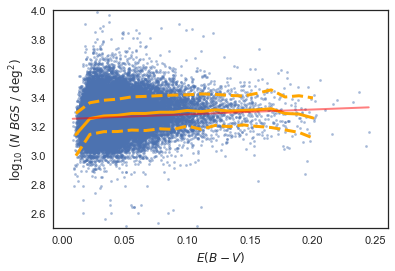

In [31]:
coeff = density_vs_ebv(info, 'BGS', order=1, ylim=(2.5, 4))